In [1]:
from helper_functions import *

/home/gc/VS-Projects/CIFAR-100-CNN-experiment/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CIFAR 100 CNN EXPERIMENT

## CIFAR-10 proof of concept model

### prepare dataset

In [2]:
#get dataset

CIFAR_10_train = torchvision.datasets.CIFAR10(
    root="datasets/", 
    train=True, 
    download=True,
    transform=ToTensor(),
    target_transform=None
)

CIFAR_10_test = torchvision.datasets.CIFAR10(
    root="datasets/", 
    train=False, 
    download=True,
    transform=ToTensor(),
    target_transform=None
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
#check train test length
len(CIFAR_10_test), len(CIFAR_10_train)

(10000, 50000)

In [4]:
#see CIFAR-10 classes
class_names = CIFAR_10_train.classes
class_to_idx = CIFAR_10_train.class_to_idx
print(class_names, "\n\n", class_to_idx)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

 {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [5]:
#see tensor shape
image, label = CIFAR_10_test[0]
image.shape

torch.Size([3, 32, 32])

### visualise dataset

(-0.5, 31.5, 31.5, -0.5)

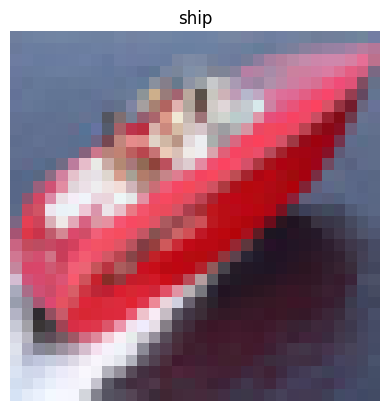

In [6]:
#see random data samples

rand_n = torch.randint(0, len(CIFAR_10_train), size=[1])
v_image, v_label = CIFAR_10_train[rand_n]
plt.imshow(v_image.permute(1, 2, 0))
plt.title(class_names[v_label])
plt.axis(False)

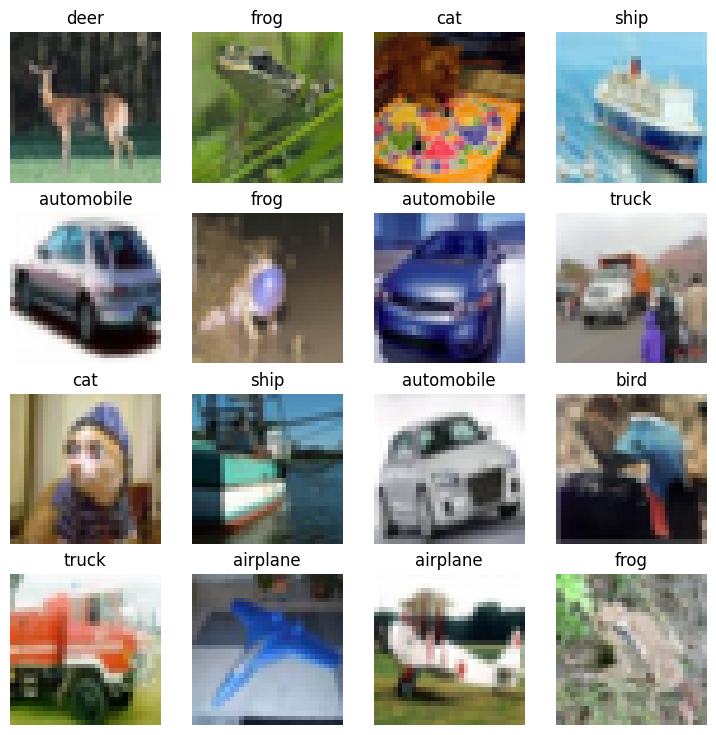

In [7]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    rand_n = torch.randint(0, len(CIFAR_10_train), size=[1])
    v_image, v_label = CIFAR_10_train[rand_n]
    fig.add_subplot(rows, cols, i)
    plt.imshow(v_image.permute(1, 2, 0))
    plt.title(class_names[v_label])
    plt.axis(False)

### prepare dataloader

In [8]:
BATCH_SIZE = 32

c10_train = DataLoader(dataset=CIFAR_10_train, batch_size=BATCH_SIZE, shuffle=True)

c10_test = DataLoader(dataset=CIFAR_10_test, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
#how many batches
len(c10_test), len(c10_train)

(313, 1563)

### create baseline model

In [10]:
#HYPERPARAMETERS
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
EPOCHS = 5

In [19]:
class CIFAR10_Modelv0(nn.Module):

    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.layer_1 = nn.Flatten()
        self.layer_2 = nn.Linear(in_features=input_shape, out_features=hidden_units)
        self.layer_3 = nn.Linear(in_features=hidden_units, out_features=output_shape)

    def forward(self, x):
        x = self.layer_1(x)
        #print("1  ", x.shape)
        x = self.layer_2(x)
        #print("2  ", x)
        x = self.layer_3(x)
        #print("3  ", x, "\n\n------\n\n")
        return x

In [20]:
model_0 = CIFAR10_Modelv0(
    input_shape=3072,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
)

In [21]:
#loss and optim

v0_loss = nn.CrossEntropyLoss()

v0_optimizer = torch.optim.SGD(params=model_0.parameters(), lr=LEARNING_RATE)

### test baseline model

In [22]:
time_start = timer()

for epoch in tqdm(range(EPOCHS)):

    train_step(
        model=model_0,
        dataloader=c10_train,
        loss_fn=v0_loss,
        optimizer=v0_optimizer,
        accuracy_fn=accuracy_fn
    )

    test_step(
        model=model_0,
        dataloader=c10_test,
        loss=v0_loss,
        accuracy_fn=accuracy_fn
    )

end_time = timer()

total = print_train_time(time_start, end_time)

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.1435 | train acc: 22.76


 20%|██        | 1/5 [00:17<01:08, 17.06s/it]

test loss: 2.0602 | test acc: 27.45
train loss: 2.0190 | train acc: 28.55


 40%|████      | 2/5 [00:32<00:47, 16.00s/it]

test loss: 1.9885 | test acc: 30.22
train loss: 1.9613 | train acc: 31.05


 60%|██████    | 3/5 [00:46<00:29, 14.95s/it]

test loss: 1.9433 | test acc: 32.24
train loss: 1.9210 | train acc: 33.01


 80%|████████  | 4/5 [01:03<00:16, 16.02s/it]

test loss: 1.9059 | test acc: 33.84
train loss: 1.8899 | train acc: 34.20


100%|██████████| 5/5 [01:21<00:00, 16.34s/it]

test loss: 1.8786 | test acc: 34.43

Train time on None: 81.733 seconds


In [23]:
model_0_results = eval_model(
    model=model_0,
    data_loader=c10_test,
    loss_fn=v0_loss,
    accuracy_fn=accuracy_fn
)

print(model_0_results)

{'model_name': 'CIFAR10_Modelv0', 'model_loss': 1.8786053657531738, 'model_acc': 34.43490415335463}


### model v1

In [42]:
#HYPERPARAMETERS
HIDDEN_UNITS = 9
LEARNING_RATE = 0.1
EPOCHS = 5

In [43]:
#create network

class CIFAR10_Modelv1(nn.Module):

    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      groups=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      groups=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      groups=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      groups=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [44]:
model_1 = CIFAR10_Modelv1(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
)

In [45]:
#loss and optim

v1_loss = nn.CrossEntropyLoss()

v1_optimizer = torch.optim.SGD(params=model_1.parameters(), lr=LEARNING_RATE)

In [46]:
time_start = timer()

for epoch in tqdm(range(EPOCHS)):

    train_step(
        model=model_1,
        dataloader=c10_train,
        loss_fn=v1_loss,
        optimizer=v1_optimizer,
        accuracy_fn=accuracy_fn
    )

    test_step(
        model=model_1,
        dataloader=c10_test,
        loss=v1_loss,
        accuracy_fn=accuracy_fn
    )

end_time = timer()

total = print_train_time(time_start, end_time)

  0%|          | 0/5 [00:00<?, ?it/s]

train loss: 2.1221 | train acc: 20.79


 20%|██        | 1/5 [01:01<04:04, 61.20s/it]

test loss: 1.8174 | test acc: 34.49
train loss: 1.7052 | train acc: 39.16


 40%|████      | 2/5 [02:04<03:07, 62.63s/it]

test loss: 1.6264 | test acc: 42.23
train loss: 1.5983 | train acc: 43.23


 60%|██████    | 3/5 [03:27<02:23, 71.83s/it]

test loss: 1.5602 | test acc: 44.91
train loss: 1.5042 | train acc: 46.94


 80%|████████  | 4/5 [05:00<01:20, 80.32s/it]

test loss: 1.5815 | test acc: 45.05
train loss: 1.4365 | train acc: 49.72


100%|██████████| 5/5 [07:59<00:00, 95.82s/it] 

test loss: 1.4690 | test acc: 47.61

Train time on None: 479.087 seconds


In [48]:
model_1_results = eval_model(
    model=model_1,
    data_loader=c10_test,
    loss_fn=v1_loss,
    accuracy_fn=accuracy_fn
)

print(model_1_results)

{'model_name': 'CIFAR10_Modelv1', 'model_loss': 1.4690452814102173, 'model_acc': 47.6138178913738}


### model v2

from 9 -> 27 hidden units

In [49]:
#HYPERPARAMETERS
HIDDEN_UNITS = 27
LEARNING_RATE = 0.1
EPOCHS = 5

In [50]:
#create network

class CIFAR10_Modelv2(nn.Module):

    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      groups=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      groups=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      groups=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      groups=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [51]:
model_2 = CIFAR10_Modelv2(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
)

In [52]:
#loss and optim

v2_loss = nn.CrossEntropyLoss()

v2_optimizer = torch.optim.SGD(params=model_2.parameters(), lr=LEARNING_RATE)

In [53]:
time_start = timer()

for epoch in tqdm(range(EPOCHS)):

    train_step(
        model=model_2,
        dataloader=c10_train,
        loss_fn=v2_loss,
        optimizer=v2_optimizer,
        accuracy_fn=accuracy_fn
    )

    test_step(
        model=model_1,
        dataloader=c10_test,
        loss=v2_loss,
        accuracy_fn=accuracy_fn
    )

end_time = timer()

total = print_train_time(time_start, end_time)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
model_2_results = eval_model(
    model=model_2,
    data_loader=c10_test,
    loss_fn=v2_loss,
    accuracy_fn=accuracy_fn
)

print(model_2_results)

{'model_name': 'CIFAR10_Modelv1', 'model_loss': 1.4690452814102173, 'model_acc': 47.6138178913738}
